# Python Riskcloud Library

This notebook demos the riskcloudpy library. The library interfaces with LogicGate's API providing the user access to the endpoints. The library is only compatible with the QA environment and requires a username and password. In this demo, data is retrieved from the API and standard data science techniques are applied using Python's built in libraries Pandas and Matplotlib.

### Installing Libraries
First, the relevant libraries are installed. Note the `riskcloudpy` is the first library to be installed.

In [14]:
import sys
!{sys.executable} -m pip install riskcloudpy #LogicGate's risk cloud python library
!{sys.executable} -m pip install pandas      #Pandas data manipulation and analysis library
!{sys.executable} -m pip install matplotlib  #Matplotlib plotting library

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


### Importing Libraries
Next, python requires the user to import the libraries he/she wants to use in the notebook (note that this is different than installing. To import a library, it must first be installed). In this case, all installed libraries are imported using keyword `import`. Note that `riskcloudpy` and `matplotlib` are followed by `.session` and `.pyplot`, respectively. These are specific classes within the libraries. Only these classes will be used and all others ignored. When these libraries are refrenced in code, they are actually refering to these specific classes. Finally, each library import is as assigned an alias with the key word `as`. The libraries are refrenced with these aliases later on in the code.

In [15]:
import riskcloudpy.session as Session
import pandas as pd
import matplotlib.pyplot as plt

### API Authentication and Requests
The url of the LG's QA enviornment is provided along with a username and password. These are passed to our `riskcloudpy.session` class using alias `Session`. The class establishes a connection to LogicGate's QA API behind the scenes. Once the connection is established, specific data is retrieved. Here, it is data on all applications in the current enviornment (QA). After each data request is made, the request response is captured with variables `r`. The variable `r`'s `status_code` field should be 200 if a succesfull connection is made. This is checked with the assertion. Note that `Session` has it's own `authentication_status` field as well.

In [17]:
base_url = ''
username = ""
password = ""

session = Session.Session(username,password,base_url)
assert(session.authentication_status==200)

r = session.users()
assert(r.status_code==200)
dfUsers = pd.DataFrame(r.json())

r = session.applications()
assert(r.status_code==200)

AttributeError: 'Session' object has no attribute 'users'

### Convert Json Reponse into Dataframe
The output of the last request (application endpoint) is captured in `r`. It is next converted to json format and placed within a pandas dataframe. The dataframe is a table of data and acts as the basic building block for data science. The dataframe is displayed as a table in the output.

In [5]:
df = pd.DataFrame(r.json())
df.head(5) #Print the first 5 rows of the dataframe. It will appear as a table.

,id,active,created,updated,name,color,icon,type,permissionsEnabled,imported,copied,live
0,J2En8ZMb,True,1539952086237,1.541103e+12,TR Tester,#00facc,fas__fa-gift,None,False,False,False,False
1,POHBBCp8,True,1539917810874,1.539918e+12,Table Report Town,#00a3de,fas__fa-cubes,None,False,False,False,False
2,hGGJzT1z,True,1540229243265,1.540319e+12,Elizabeth QA,#fa0096,fas__fa-heartbeat,None,False,False,False,False
3,pEyPfJRE,True,1540218415374,1.544743e+12,Attachments,#fdae60,fas__fa-exclamation-triangle,None,False,False,False,False
4,AyuF1oAr,True,1540236339092,1.554739e+12,TR Tester (Copy),#00facc,fas__fa-gift,None,False,False,False,False


### Data Cleaning: Convert Time Series Data to CST Time
This section is more technical and is often refered to as "data cleaning". Within the created and updated column, the time is recored in Unix millisecond time. This standard defines time in milliseconds relative to January 1st 1970 UTC. Python and pandas provide a number of built in functions to convert Unix time to central standard time.

In [6]:
#created and updated are in Unix ms time. Convert to date time
df['created'] = pd.to_datetime(df['created'], unit='ms')
df['updated'] = pd.to_datetime(df['updated'], unit='ms')

#set time zone to UTC and convert to US/Central
df.created = df.created.dt.tz_localize('UTC').dt.tz_convert('US/Central')
df.updated = df.updated.dt.tz_localize('UTC').dt.tz_convert('US/Central')

#get todays date (will be used later)
today = pd.to_datetime('today').normalize()
today = today.tz_localize('US/Central')

### Hour of Creation: Plot Dataframe
Now that the data has been cleaned, it's time to plot the data. First, the creation time is investigated using a bar graph. Note that this is effectively a histogram where the x-axis is the hour of creation (often referred to as bins) and the y-axis is the number of applictionas with that hour of creation (number of items per bin).

Text(0.5, 1.0, 'Number of Applications vs. Hour of the Day of Creation (CST)')

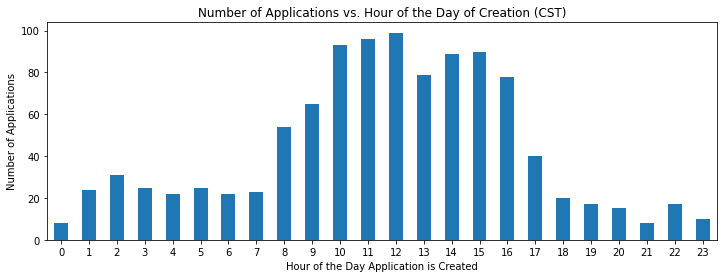

In [7]:
fig, axs = plt.subplots(figsize=(12,4))
df.groupby(df['created'].dt.hour).size().plot(kind='bar',rot=0,ax=axs)
plt.xlabel("Hour of the Day Application is Created")
plt.ylabel("Number of Applications")
plt.title("Number of Applications vs. Hour of the Day of Creation (CST)")

### Updated and Created Time: Plot Dataframe
Next, the update and activate time are plotted. The data is displayed as a scatter plot. Each point is assigned a color associated with the app's color (this is just for fun!). The graph shows that there are some applications in QA that were created and upated prior to 2019. These app may be worth investigating and deleting, to reduce clutter. Next, we will identify these apps by their id and name.

Text(0.5, 1.0, 'Application Update Date vs. Creation Date with App Color')

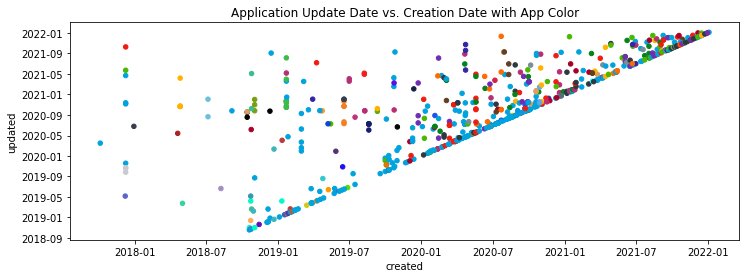

In [8]:
fig, axs = plt.subplots(figsize=(12,4))
df.plot(x='created',y='updated',kind='scatter',ax=axs,c='color')
plt.title("Application Update Date vs. Creation Date with App Color")

### Updated and Created: Tabulate Dataframe
A dataframe is very easy to manipulate. The `update` column is filtered to only display values before the `cutoff` (which is January 1st, 2019). Next, the dataframe is sorted by `updated` in ascending order. The `name`, `color` and `id` are all displayed as well.

In [9]:
cutoff = pd.to_datetime('2019-01-01')
cutoff = cutoff.tz_localize('US/Central')

df[df['updated']<cutoff].sort_values(by='updated',ascending=True)[['name','updated','color','id']]

,name,updated,color,id
1,Table Report Town,2018-10-18 21:57:03.155000064-05:00,#00a3de,POHBBCp8
5,Test,2018-10-22 20:30:25.187000064-05:00,#00a3de,ebNCQoQ1
2,Elizabeth QA,2018-10-23 13:22:46.036000-05:00,#fa0096,hGGJzT1z
10,TR Tester (Copy),2018-11-01 15:17:19.003000064-05:00,#00facc,1yLVnuUh
0,TR Tester,2018-11-01 15:17:20.228000-05:00,#00facc,J2En8ZMb
11,Szuyin,2018-11-20 09:00:06.296000-06:00,#5b12b8,14beb88h
13,Conditional Copy Test,2018-12-03 09:07:47.928000-06:00,#00a3de,QeiqcCWq
14,Conditional Copy Test (Copy),2018-12-03 09:10:18.871000064-06:00,#00a3de,4j4t13r6
15,SLA,2018-12-06 19:12:11.937999872-06:00,#00a3de,3646jfX3
3,Attachments,2018-12-13 17:18:59.113999872-06:00,#fdae60,pEyPfJRE


### Active Time: Plot Data
Next, the most active apps are explored. The word "active" is defined as the difference between updated and created. Apps with large active time possess old created and recent updated values. Therefore, despite an old created time, the app has recently been remebered by a user and updated. It may be  worth while determining why these apps are still deemed useful. 

In [10]:
df['active']= (df.updated-df.created).dt.days

The second value calculated is "best active". It is defined similarly to active. However, it is now the difference of today's date with created. This gives the best possible active value for all apps. An app's active value can not be larger than its best active.

In [11]:
df['best active']= (today-df.created).dt.days

Combining the active and best active values, a scatter plot shows the active times while a line plot shows best active times. Once again, the color corresponds to the app's color, and is just for fun.

Text(0, 0.5, 'active (days)')

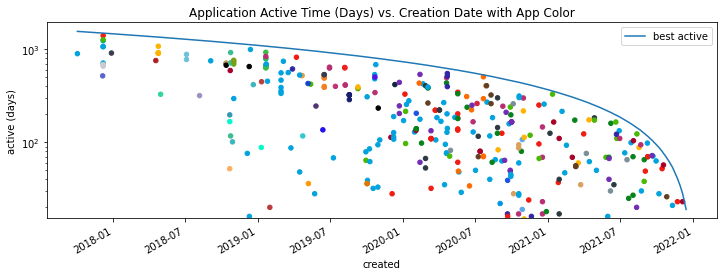

In [12]:
fig, axs = plt.subplots(figsize=(12,4))
df[df.active>0.0].plot(x='created',y='active',kind='scatter',ax=axs,logy=True, c='color')
df[df.active>0.0].plot(x='created',y='best active',kind='line',ax=axs,logy=True)
plt.title("Application Active Time (Days) vs. Creation Date with App Color")
plt.ylabel("active (days)")

### Active Time: Tabulate Data
Now, the active time is displayed in table form. The dataframe is sorted by `active` in descending order. The `name`, `created`, `color` and `id` of the app are all displayed. Only the first ten apps are shown.

In [13]:
df.sort_values(by=['active'],ascending=[False])[['name','active','created','color','id']].head(10)

,name,active,created,color,id
239,Enterprise Risk Management,1400.0,2017-12-07 12:22:51.113000-06:00,#f01c11,3KEd0gV2
734,Testing - DK (Copy),1262.0,2017-12-07 12:22:51.113000-06:00,#49b800,5WaA0XOE
667,Enterprise Risk Management (Q2 2021 Showcase),1231.0,2017-12-07 12:22:51.113000-06:00,#00a3de,Zl4RzNqz
188,Business Continuity Plan Management,1076.0,2018-04-25 13:19:31.279000-05:00,#ffb300,xT1fUdP8
260,SR-744,1069.0,2017-12-07 12:22:51.113000-06:00,#00a3de,rapRPqoA
231,ERM Import Test,1062.0,2017-12-07 12:22:51.113000-06:00,#00a3de,uUdM9XWa
18,Eric,993.0,2018-12-13 14:21:08.072000-06:00,#00a3de,pEs4EB0q
29,rfqa#,926.0,2019-01-21 08:15:35.285000-06:00,#3cbc49,iyzhCjjb
382,[AW] IT Risk,921.0,2018-10-24 17:16:56.686000-05:00,#3cbc91,FXtoyfWF
194,Fingers Crossed!,909.0,2018-04-25 13:19:31.279000-05:00,#ffb300,rxar4O3a


## User Data

Next, user data is investigated.